# DAY 1 : LLMs

## Calling OCI models

### Supported models (https://docs.oracle.com/en-us/iaas/Content/generative-ai/chat-models.htm) 
- cohere.command-r-08-2024
- cohere.command-r-16k
- cohere.command-r-plus
- cohere.command-r-plus-08-2024
- meta.llama-3.1-405b-instruct
- meta.llama-3.1-70b-instruct
- meta.llama-3.2-90b-vision-instruct
  


In [43]:
# set up the  variables


from oci.generative_ai_inference import GenerativeAiInferenceClient
from oci.generative_ai_inference.models import *
import oci

CONFIG_PROFILE = "DEFAULT"
LLM_MODEL = "cohere.command-r-16k" 
PREAMBLE = """
        you always answer in a one stanza poem.
"""
MESSAGE = """
        "why is the skyblue"
"""
compartmentId= "ocid1.compartment.oc1..aaaaaaaa5wmdeu3rf5s4rs4l66rksphne2orz4buauniiqtar63du6ni7icq" 
llm_service_endpoint= "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"

In [44]:
# oci key enabled for api access
config = oci.config.from_file('~/.oci/workshop', CONFIG_PROFILE)

# chat request      
llm_chat_request = CohereChatRequest()
llm_chat_request.preamble_override = PREAMBLE 
llm_chat_request.message = MESSAGE
llm_chat_request.is_stream = False 
llm_chat_request.max_tokens = 500 # max token to generate, can lead to incomplete responses
llm_chat_request.temperature = 1.0 # higer value menas more randon, defaul = 0.3
llm_chat_request.top_p = 0.7  # ensures only tokens with toptal probabely of p are considered, max value = 0.99, min 0.01, default 0.75
llm_chat_request.top_k = 0  #Ensures that only top k tokens are considered, 0 turns it off, max = 500
llm_chat_request.frequency_penalty = 0.0 # reduces the repeatedness of tokens max value 1.9=0, min 0,0



# set up chat details
chat_detail = ChatDetails()
chat_detail.serving_mode = OnDemandServingMode(model_id=LLM_MODEL)
chat_detail.compartment_id = compartmentId
chat_detail.chat_request = llm_chat_request

# set up the LLM client 
llm_client = GenerativeAiInferenceClient(
                config=config,
                service_endpoint=llm_service_endpoint,
                retry_strategy=oci.retry.NoneRetryStrategy(),
                timeout=(10,240))

In [45]:
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
        
print (llm_text)

The sky's blue because of a phenomenon
Scattering of sunlight, a joyous welcome
As it hits the earth, the atmosphere disposes
Ray of hope, the blue sky never falters.


### Response predictability

change teh sees and see if same seed leads to same response

In [46]:
## Play with seed
llm_chat_request.seed = 7555 # adding the seed will make response more predictable
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
        
print (llm_text)

The sky is blue because when the sun's rays shine through,
The shorter rays, scattered by the air, are blue.
So when you look up at the sky and wonder,
The blue you see is this light, dispersed and wondrous.


###  controlling the output length.  
change the length and see the stop reason

In [47]:
llm_chat_request.max_tokens = 10
llm_response = llm_client.chat(chat_detail)
print (llm_response.data.chat_response.text)
print (llm_response.data.chat_response.finish_reason)

The sky is blue because when the sun's rays
MAX_TOKENS


### Exercise 1
 *  Try different models
 *  Play with messages  and preamble
    * Zero shot
    * N shot 
    * Output format  ( freeform, bullet, json, csv, sql etc)
    * input format (text, csv, json)
    * Different languages
* Try language analysis
    * Proof reading
    * Entity extraction
    * Summarization
    * Sentiment analysis
* Data generation
    * SQL insert
    * Json
    * CSV
* Try guard rails



## History  support
for conversational bots, its important for LLM to remember the conversation so far. It is typically done via history
history comprises of messages & the roles ofr teh entity associated with the message 

In [48]:
# optionally update the PREAMBLE 
# PREAMBLE = " Answer the questions in a professional tone, based on thw conversation history"

previous_chat_message = oci.generative_ai_inference.models.CohereUserMessage(message="Tell me something about Oracle.")
previous_chat_reply = oci.generative_ai_inference.models.CohereChatBotMessage(message="Oracle is one of the largest vendors in the enterprise IT market and the shorthand name of its flagship product. The database software sits at the center of many corporate IT")
#llm_chat_request.chat_history = [previous_chat_message, previous_chat_reply]

In [49]:
# ask the question 
llm_chat_request.seed = None
#llm_chat_request.message = "Where is Oracle's HQ?"
llm_chat_request.message = "what is its flagship product?"

llm_response = llm_client.chat(chat_detail)


In [50]:
# Print result
print("**************************Chat Result**************************")
llm_text = llm_response.data.chat_response.text
print(llm_text)

**************************Chat Result**************************
Microsoft's flagship product, a revolution in the digital


### Exercise 2 
Create an conversational bot 

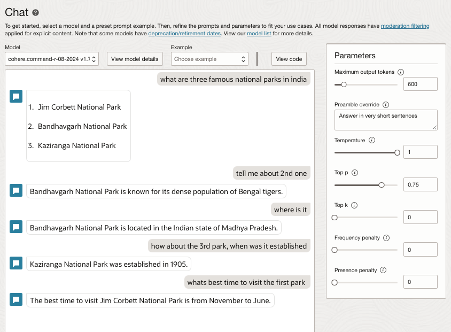

##  JSON format

### note this is only availble for 08-2024 models
### good habit its to specify JSON generation in preamble 

read restrictions here: https://docs.cohere.com/docs/structured-outputs-json#schema-constraints


In [51]:
# change top the supported model
chat_detail.serving_mode = OnDemandServingMode(model_id="cohere.command-r-08-2024")
llm_chat_request.response_format = CohereResponseJsonFormat()
llm_chat_request.preamble_override = "Answer in json format"
llm_chat_request.message = "list 3 Latest novels from indian authors "

llm_chat_request.max_tokens = 500
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)

  


{
  "Indian Novels": [
    {
      "Title": "A Flame for Freedom: The Bhagat Singh Story",
      "Author": "Anuj Dhar",
      "Year": "2023"
    },
    {
      "Title": "The Ancestor",
      "Author": "M.G. Vassanji",
      "Year": "2022"
    },
    {
      "Title": "The Shadow King",
      "Author": "Anuk Arudpragasam",
      "Year": "2020"
    }
  ]
}


In [52]:
response_schema = {
            "type": "object",
            "required": ["title", "author", "publication_year"],
            "properties": {
                "title": {"type": "string"},
                "author": {"type": "string"},
                "publication_year": {"type": "integer"},
            },
        }

llm_chat_request.response_format = CohereResponseJsonFormat(schema = response_schema)
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)


{
  "title": "Latest Novels from Indian Authors",
  "author": "Nitin Gandhi",
  "publication_year": 2023
}


### nested schema with array

In [53]:
response_schema = {
            "type": "object",
            "required": ["authors"],
            "properties" : {
                "authors" : {
                        "type" : "array",
                        "items" : {
                                "type" : "object",
                                "required": ["title", "author", "publication_year"],
                                "properties": {
                                        "title": {"type": "string"},
                                        "author": {
                                                "type": "object",
                                                "required" : ["fname", "lname"],
                                                "properties" : {
                                                        "fname" : {"type":"string"},       
                                                        "lname" : {"type":"string"}
                                                }
                                        },
                                        "publication_year": {"type": "integer"}
                                }
                        }        
                }
            }
        }

llm_chat_request.response_format = CohereResponseJsonFormat(schema = response_schema)
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)

{
  "authors": [
    {
      "title": "A Fire Story",
      "author": {
        "fname": "Piyush",
        "lname": "Pande"
      }
   
,
      "publication_year": 2023
    },
    {
      "title": "Sita's Ramayana",
      "author": {
        "fname": "Devdutt",
        "lname": "Pattanayak"
      },
      "publication_year": 2023
    },
    {
      "title": "The Midnight Library",
      "author": {
        "fname": "Matoshree",
        "lname": "Khandekar"
      },
      "publication_year": 2023
    }
  ]
}


### Exercise three
 * Create a program to
    * Create 2 stanza poem about a famous Indian personality
    * Ask llm extract set of entities
    * Specify the output schema with fixed fields

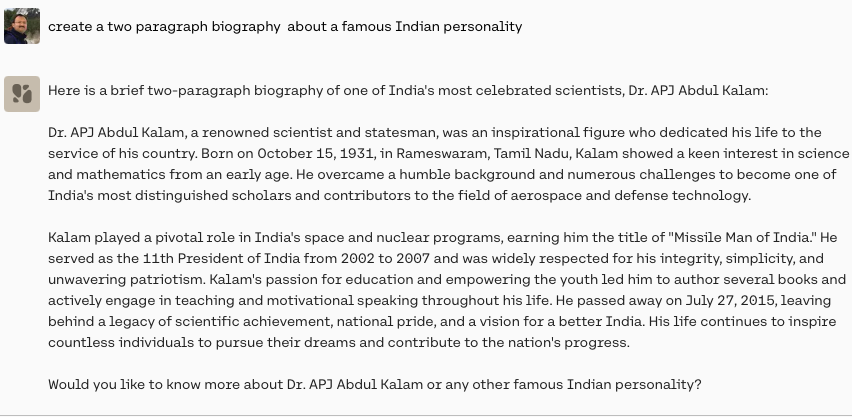
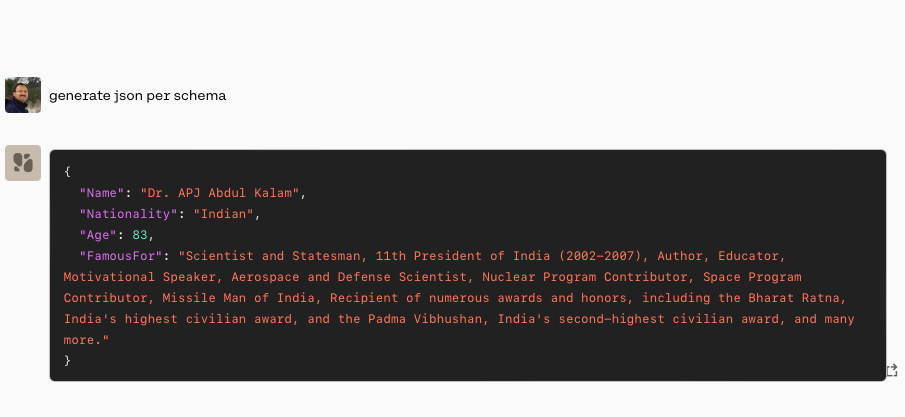

## Streaming response

OCI support SSE for streaming the response each token as its generated 

In [54]:

#ask the question 
llm_chat_request.preamble_override = "Answer as a poem" 
llm_chat_request.message = "why is sky blue"
llm_chat_request.is_stream = True 
llm_chat_request.response_format = CohereResponseTextFormat()

# geerate response
llm_response = llm_client.chat(chat_detail)

# stream twh output
import json 
for event in llm_response.data.events():
    res = json.loads(event.data)
    if 'finishReason' in res.keys():
        print(f"\nFinish reason: {res['finishReason']}")
        break
    if 'text' in res:
        print(res['text'], end="", flush=True)
print("\n")



A question so pure, a mystery so old,
Why the sky appears blue, a tale to be told.

The sun, a brilliant star, shines light so bright,
Its rays dance and play, a heavenly sight.

When sunlight meets the air, a wonder unfolds,
Tiny particles scatter, a dance it entails.
Blue hues, they reflect, a magical show,
While other colors slip by, a vibrant glow.

So, up in the sky, a blue canvas we see,
A nature's masterpiece, a gift for us, you and me.

Though science may explain, a fact to be found,
The sky's blue embrace, a beauty profound.
Finish reason: COMPLETE


